# Libraries

In [1]:
##########==========##########==========##########==========##########==========

## libraries
#import sys
#!{sys.executable} -m pip install python-docx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import docx

## general purpose visualization settings
set_font = {'L':60, 'M':40, 'S': 20}
set_color = {'Foreground':'#000000', 'Photo':'#202020', 'Visit':'#404040',
             'Unvisit':'#606060', 'Background':'#808080'}

## general purpose data
city_list = pd.read_excel('A_Input/city_list.xlsx')

# Basic Dashboard Architecture

Style: Define custom style elements for the visualization

In [2]:
## computations
def define_style():
    pass
## test
def test_style():
    pass

Layout: Make the layout underlying the visualization

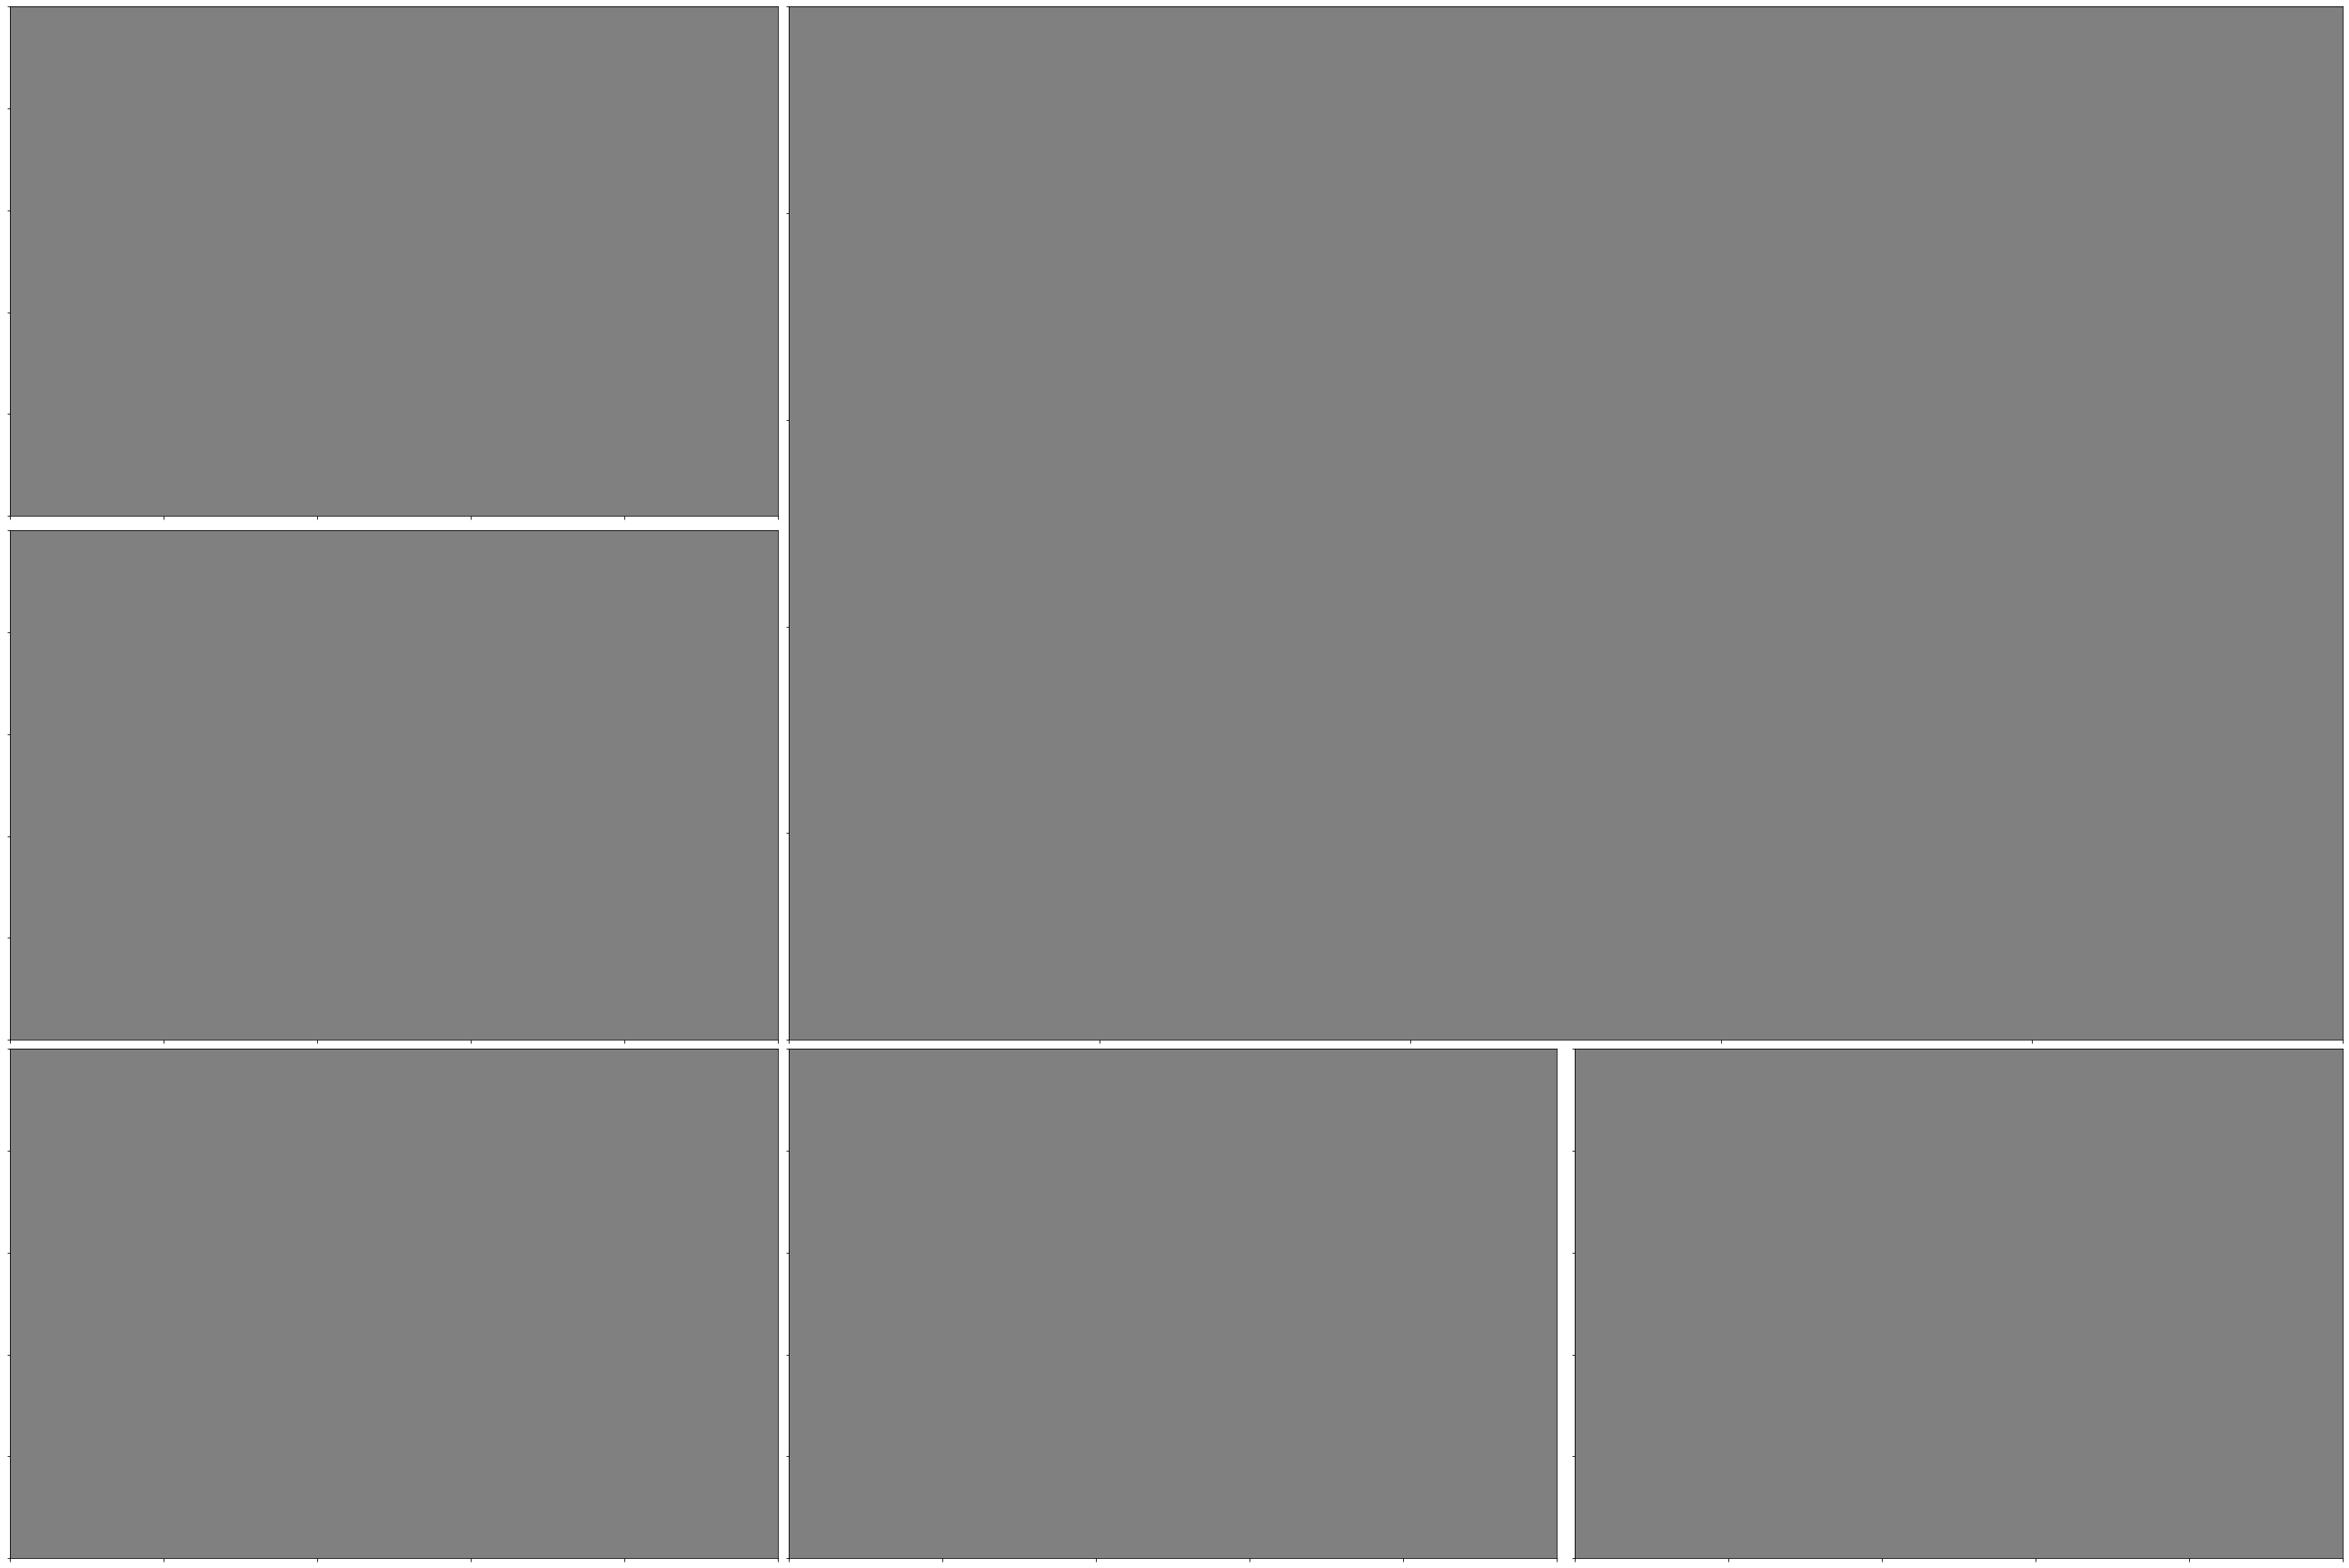

In [3]:
## computations
def process_layout():
    
    ## import needed objects
    from matplotlib.pyplot import figure
    from matplotlib.gridspec import GridSpec
    from matplotlib.colors import hsv_to_rgb
    
    ## generate segmented plotting space
    dashboard_figure = figure(
        figsize = (36, 24),
        constrained_layout = True
        )
    fig_grid  = GridSpec(3, 3,
                         figure = dashboard_figure,
                         wspace = 0.01,
                         hspace = 0.01
                        )
    
    ## define each plot panel
    axis_travels = dashboard_figure.add_subplot(fig_grid[0:2, 1:3])

    axis_explanation = dashboard_figure.add_subplot(fig_grid[0, 0])
    axis_progress    = dashboard_figure.add_subplot(fig_grid[1, 0])
    axis_routes      = dashboard_figure.add_subplot(fig_grid[2, 0])

    axis_opportunity = dashboard_figure.add_subplot(fig_grid[2, 1])
    axis_legend_plus = dashboard_figure.add_subplot(fig_grid[2, 2])
    
    ## package results
    dashboard = {'travels': axis_travels,
                   'explanation': axis_explanation,
                   'routes': axis_routes,
                   'progress': axis_progress,
                   'opportunity': axis_opportunity,
                   'legend_plus': axis_legend_plus}
    for iter in dashboard.keys():
        dashboard[iter].tick_params(
            labelbottom = False,
            labeltop = False,
            labelleft = False,
            labelright = False
            )
        dashboard[iter].set_facecolor( set_color['Background'] )
    
    ## return results
    return dashboard_figure, dashboard

dashboard_figure, dashboard = process_layout()

## display
def display_layout(the_figure):
    the_figure.savefig("C_Output/us_travels.png")
    the_figure.savefig("C_Output/us_travels.pdf")

## test
def test_layout():
    print("Have you visually confirmed that the diagram matches dashboard_plan.pptx?")
    print("Have you converted the bar chart coordinate data to long format?")

# Non-Map Dashboard Panels

Explanation: Make explanation / introduction text panel

In [4]:
## helper functions - reads in docx files
def read_docx(address):
    x = docx.Document(address)
    y = []
    for i in x.paragraphs:
        y.append(i.text)
    return y

## computations
def process_explanation(file_address):
    
    ## read in explanatory text
    explain = read_docx(file_address)
    
    ## package as pandas object
    explain = {'x': 0, 'y':0, 's': explain}
    explain = pd.DataFrame(explain)
    explain['y'] = [8 - (i * 0.25) for i in range(1, len(explain) + 1)]
    
    return explain



## display
def display_explanation(explain):
    dashboard['explanation'].set_xlim(0, 12)
    dashboard['explanation'].set_ylim(0, 8)
    for i in range(explain.shape[0]):
        dashboard['explanation'].text(explain['x'][i], explain['y'][i], explain['s'][i])



## test
def test_explanation():
    pass

## execute
explanation = process_explanation('A_Input/explanation.docx')
display_explanation(explanation)


Progress: Make horizontal bar charts depicting progress towards city and state travel goals

In [5]:
## computations
def process_progress(x = city_list):
    
    ## identify unvisited cities
    city_list['Unvisit'] = 1 - city_list['Visit']
    
    ## tabulate summary statistics (state_level)
    state_stats = city_list[['State', 'Photo', 'Visit', 'Unvisit']]
    state_stats = state_stats.groupby('State').max().drop(['CAN', 'PR', 'DC'])
    state_stats['Visit'] = state_stats['Visit'] - state_stats['Photo']
    state_stats['Unvisit'] = 1 - (state_stats['Visit'] + state_stats['Photo'])
    state_stats = state_stats.sum()

    ## tabulate summary statistics (city-level)
    city_list['Visit'] = city_list['Visit'] - city_list['Photo']
    city_stats = city_list[['Photo', 'Visit', 'Unvisit']].sum()
    
    ## package and return data
    y = pd.DataFrame({
        'City': city_stats,
        'State': state_stats
    })
    y = pd.melt(y, ignore_index = False).reset_index()
    y.columns = ['Status', 'Entity', 'Count']
    return y

## display
def display_progress(x):
    
        ## set useful measurements
    use_measure = {'bar_start': 1.0, 'bar_height': 3 / 5}
    
    ## scale counts to match plotting coordinates
    func = lambda a: np.cumsum(a / sum(a))
    scaled_count = x[['Entity', 'Count']].groupby('Entity')
    scaled_count = scaled_count.transform(func)
    x['X'] = (scaled_count * (4.4 - use_measure['bar_start']))
    del scaled_count, func
    
    ## generate y coordinates
    x['Y'] = (x['Entity'] == 'State').astype(int)
    
    ## render horizontal barplots
    dashboard['progress'].set_xlim(0, 4.5)
    dashboard['progress'].set_ylim( 0 - (1 - use_measure['bar_height']), 2.8)
    for i in ['Unvisit', 'Visit', 'Photo']:
        dashboard['progress'].barh(
            y = x.loc[x['Status'] == i, 'Entity'],
            width = x.loc[x['Status'] == i, 'X'], 
            height = use_measure['bar_height'],
            left = use_measure['bar_start'],
            align = 'edge',
            color = set_color[i]
            )
        
    ## render bar count labels
    for i in range(x.shape[0]):
        if x['Count'].astype(int)[i] > 3:
            dashboard['progress'].text(
                x = x['X'][i] - 0.01 + use_measure['bar_start'],
                y = x['Y'][i] + 0.02,
                s = x['Count'].astype(int)[i],
                color = set_color['Foreground'],
                fontsize = set_font['S'],
                horizontalalignment = 'right',
                verticalalignment = 'bottom',
                bbox = dict(pad = 0.1, fc = '#FFFFFF88', ec = '#FFFFFF00',
                            boxstyle = 'Round', mutation_aspect = 1.1)
                )
    ## render legend
    dashboard['progress'].legend(
        labels = ['Unvisited', 'Visited', 'Photographed'],
        fontsize = set_font['S']
        )
    

## test
def test_progress(x):
    pass

## execute
progress = process_progress()
display_progress(progress)

In [6]:
'''
## computations
def process_progress(prog):

    ## make results container
    score = np.zeros((2, 4))
    score = pd.DataFrame(score,
                         index = ['Cities', 'States'],
                         columns = ['Photographed', 'Visited', 'Unvisited', 'Total']
                        )

    ## tabulate city statistics
    score['Photographed'].at['Cities'] = sum(prog['Photo'])
    score['Visited'].at['Cities'] = sum(prog['Visit']) - sum(prog['Photo'])
    score['Unvisited'].at['Cities'] = prog.shape[0] - sum(prog['Visit'])
    score['Total'].at['Cities'] = prog.shape[0]

    ## tabulate state statistics
    state_tab = prog[['State', 'Visit', 'Photo']].groupby('State').sum()
    state_tab = state_tab.drop(index = ['DC', 'PR', 'CAN'])
    score['Photographed'].at['States'] = sum(state_tab['Photo'] > 0)
    score['Visited'].at['States'] = sum(state_tab['Visit'] > 0) - sum(state_tab['Photo'] > 0)
    score['Unvisited'].at['States'] = sum(state_tab['Visit'] == 0)
    score['Total'].at['States'] = 50
    
    return score

## display
def display_progress(prog):
    
    ## create percentage version of prog
    prog_scaled = prog.copy()
    for i in ['Photographed', 'Visited', 'Unvisited']:
        prog_scaled[i] = prog_scaled[i] / prog_scaled['Total']
    
    ## render bars
    dashboard['progress'].barh(
        y = prog.index,
        width = prog_scaled['Photographed'],
        height = 0.6,
        label = 'Photographed',
        color = '#000000',
        edgecolor = 'black',
        align = 'edge'
    )
    dashboard['progress'].barh(
        y = prog.index,
        width = prog_scaled['Visited'],
        height = 0.6,
        left = prog_scaled['Photographed'],
        label = 'Visited',
        color = '#444444',
        edgecolor = 'black',
        align = 'edge'
    )
    dashboard['progress'].barh(
        y = prog.index,
        width = prog_scaled['Unvisited'],
        height = 0.6,
        left = prog_scaled['Photographed'] + prog_scaled['Visited'],
        label = 'Unvisited',
        color = '#888888',
        edgecolor = 'black',
        align = 'edge'
    )
    
    ## define axes
    dashboard['progress'].set_xlim(-0.4, 1.05)
    dashboard['progress'].set_ylim(-0.4, 2.4)
    dashboard['progress'].legend()
    
    ## label city/state bars
    for i in range(2):
        dashboard['progress'].text(
            x = [0, 0][i], 
            y = [0.3, 1.3][i], 
            s = list(prog_scaled.index)[i] + " \nVisited ",
            horizontalalignment = 'right',
            verticalalignment = 'center',
            fontsize = 60
            )
    
    ## label stacked bars
    stacked_position = prog_scaled.T.drop('Total').cumsum().iloc[[2, 0, 1]]
    stacked_position.index = prog_scaled.columns[0:3]
    stacked_position['Cities'] = stacked_position['Cities'] % 1
    stacked_position['States'] = stacked_position['States'] % 1
    prog = prog.T

    for i in stacked_position.index:
        dashboard['progress'].text(
            x = stacked_position['Cities'].loc[i] + 0.01,
            y = 0 + 0.05,
            s = int(prog['Cities'].loc[i]),
            color = 'black',
            horizontalalignment = 'left',
            fontsize = 30,
            bbox = dict(pad = 0, fc = '#FFFFFF88', ec = '#FFFFFF88')
            )
        
    for i in stacked_position.index:
        dashboard['progress'].text(
            x = stacked_position['States'].loc[i] + 0.01,
            y = 1.00 + 0.05,
            s = int(prog['States'].loc[i]),
            color = 'black',
            horizontalalignment = 'left',
            fontsize = 30,
            bbox = dict(pad = 0, fc = '#FFFFFF88', ec = '#FFFFFF88')
            )
    
## test
def test_progress():
    pass

## execution
progress = process_progress(city_list)
display_progress(progress)
'''

'\n## computations\ndef process_progress(prog):\n\n    ## make results container\n    score = np.zeros((2, 4))\n    score = pd.DataFrame(score,\n                         index = [\'Cities\', \'States\'],\n                         columns = [\'Photographed\', \'Visited\', \'Unvisited\', \'Total\']\n                        )\n\n    ## tabulate city statistics\n    score[\'Photographed\'].at[\'Cities\'] = sum(prog[\'Photo\'])\n    score[\'Visited\'].at[\'Cities\'] = sum(prog[\'Visit\']) - sum(prog[\'Photo\'])\n    score[\'Unvisited\'].at[\'Cities\'] = prog.shape[0] - sum(prog[\'Visit\'])\n    score[\'Total\'].at[\'Cities\'] = prog.shape[0]\n\n    ## tabulate state statistics\n    state_tab = prog[[\'State\', \'Visit\', \'Photo\']].groupby(\'State\').sum()\n    state_tab = state_tab.drop(index = [\'DC\', \'PR\', \'CAN\'])\n    score[\'Photographed\'].at[\'States\'] = sum(state_tab[\'Photo\'] > 0)\n    score[\'Visited\'].at[\'States\'] = sum(state_tab[\'Visit\'] > 0) - sum(state_tab[\'Photo

Legend Plus: Display table with legend and other information about planned routes

In [7]:
## computations
def process_legend_plus():
    pass
## display
def display_legend_plus():
    pass
## test
def test_legend_plus():
    pass

# Map Dashboard Panels

Map: Make the background map underlying the map panels
+ Need to evaluate different options for AK, HI, PR insets

In [8]:
## computations
def process_map():
    pass
## display
def display_map():
    pass
## test
def test_map():
    pass

Routes: Map planned routes

In [9]:
## computations
def process_routes():
    pass
## display
def display_routes():
    pass
## test
def test_routes():
    pass

Opportunity: Map geographic areas where visit will contribute to goals
+ Kernel density heat map with plasma color scaling

In [10]:
## computations
def process_opportunity():
    pass
## display
def display_opportunity():
    pass
## test
def test_opportunity():
    pass

Travels: Map past travels

In [11]:
## computations
def process_travels():
    pass
## display
def display_travels():
    pass
## test
def test_travels():
    pass

# Finish Rendering Visualization

In [12]:
display_layout(dashboard_figure)
test_layout()

Have you visually confirmed that the diagram matches dashboard_plan.pptx?
Have you converted the bar chart coordinate data to long format?
